In [1]:
# !pip install tweet-preprocessor
# !pip install sastrawi
# !pip install emoji
# !pip install PySastrawi
# !pip install scikit-learn==1.6.0

### ***Import Libraries***

In [2]:
import pandas as pd
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.Stemmer.Stemmer import Stemmer
from nltk.corpus.reader.twitter import TweetTokenizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import re
import string
import nltk
from nltk.corpus import stopwords
import numpy as np
from sklearn.model_selection import train_test_split

# Naive-Bayes' Package
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline

### ***Data Preprocessing***

In [3]:
class TextCleaning:
    def __init__(self, glossary, stopwords):
        self.glossary = dict(zip(glossary['slang'], glossary['formal']))
        self.stopwords = list(stopwords)
        self.factory = StemmerFactory()
        self.stemmer = self.factory.create_stemmer()
        self.tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)

    def clean_text(self, text):
        #tokenize tweet

        text_tokens = self.tokenizer.tokenize(text)

        text_clean = []
        for word in text_tokens:
          if (word not in self.stopwords and
              word not in string.punctuation):
            stem_word = self.stemmer.stem(word)
            text_clean.append(stem_word)
        return text_clean

    #remove punct
    def remove_punct(self, text_list):
      text = " ".join([char for char in text_list if char not in string.punctuation])
      return text

        #Fungsi Prepocessing

    def preprocess(self, text):
      text = text.lower() # lowercasing
      text = re.sub(r'[^0-9a-zA-Z]+', ' ', text) # non-alpha numeric
      text = re.sub(r'[\d+]+', '', text) # numeric
      text = re.sub(r'\\x[0-9a-fA-F]{2}', '', text) # emoji
      text = ' '.join([self.glossary[word] if word in self.glossary else word for word in text.split()]) # normalize
      text = ' '.join(['' if word in self.stopwords else word for word in text.split()]) # stopwords
      text = self.remove_punct(self.clean_text(text)) # punctuation
      return text

In [4]:
class CreateVocabulary:
    def __init__(self, dataset, preprocessor):
        self.dataset = dataset
        self.preprocessor = preprocessor

    def create_corpus(self):
        if type(self.dataset) == pd.core.frame.DataFrame:
          return list(self.dataset['remarks'])
        elif type(self.dataset) == list:
          return list(pd.concat(self.dataset)['remarks'])
        else:
          return None

    def create_vocabulary(self):
        corpus = self.create_corpus()
        vocabulary_list = [self.preprocessor.preprocess(text).split() for text in corpus]
        vocabulary = sum(vocabulary_list, [])
        vocabulary = list(set(vocabulary))
        vocabulary.sort()
        vocabulary = dict(zip(vocabulary, range(len(vocabulary))))
        return vocabulary

In [5]:
train = pd.read_csv("Dataset/train_data.csv", index_col=0).reset_index(drop=True)
test = pd.read_csv("Dataset/test_data.csv", index_col=0).reset_index(drop=True)
stopwords = pd.read_csv("Dataset/stopwords.csv")["stopwords"]
glossary = pd.read_csv("Dataset/glossary.csv", index_col=0).reset_index(drop=True)


In [6]:
preprocessor = TextCleaning(glossary=glossary, stopwords=stopwords)
vocabulary = CreateVocabulary([train, test], preprocessor).create_vocabulary()

In [7]:
text = "Saya berkunjung ke rmh kons. fu jb besok pg ada ,a .!?"
c = TextCleaning(glossary=glossary, stopwords=stopwords).preprocess(text)
print(c)

kunjung rumah konsumen follow up janji bayar besok pagi


In [8]:
print(vocabulary)

{'abai': 0, 'abang': 1, 'abar': 2, 'abd': 3, 'abdi': 4, 'abgkat': 5, 'abk': 6, 'absen': 7, 'acara': 8, 'access': 9, 'account': 10, 'aceh': 11, 'activity': 12, 'activty': 13, 'ada': 14, 'adabertemu': 15, 'adaby': 16, 'adainfo': 17, 'adajanji': 18, 'adajb': 19, 'adak': 20, 'adakons': 21, 'adaplan': 22, 'adarumah': 23, 'adasedang': 24, 'adaybs': 25, 'adc': 26, 'address': 27, 'adek': 28, 'adha': 29, 'adi': 30, 'adik': 31, 'adike': 32, 'adiknyaunit': 33, 'adisucipto': 34, 'adiyasa': 35, 'admin': 36, 'ads': 37, 'adu': 38, 'afniaty': 39, 'agency': 40, 'agenda': 41, 'agmon': 42, 'agun': 43, 'agung': 44, 'agustus': 45, 'agya': 46, 'ahanf': 47, 'ahir': 48, 'ahli': 49, 'ahmad': 50, 'air': 51, 'airmadidi': 52, 'ajak': 53, 'ajar': 54, 'aji': 55, 'ajik': 56, 'ajikpenekanan': 57, 'aju': 58, 'aka': 59, 'akam': 60, 'akansegera': 61, 'akgor': 62, 'akher': 63, 'akhie': 64, 'akhir': 65, 'akhirbulan': 66, 'akibat': 67, 'akqn': 68, 'akses': 69, 'aktf': 70, 'aktif': 71, 'aktiffam': 72, 'aktiv': 73, 'aktiviti

### ***Vectorizer***

In [9]:
count = CountVectorizer(preprocessor=preprocessor.preprocess, vocabulary=vocabulary)
X_train = count.fit_transform(train['remarks'])
X_test = count.fit_transform(test['remarks'])
y_train = train['label']
y_test = test['label']

### ***SVM Model***

In [10]:
svc = LinearSVC(C=0.01)
SVM = svc.fit(X_train, y_train)
pred_svm = SVM.predict(X_test)
print(f'confusion matrix:\n {confusion_matrix(y_test, pred_svm)}')
print("Accuracy: "+str(accuracy_score(y_test,pred_svm)))
print(classification_report(y_test, pred_svm))

confusion matrix:
 [[93  0  1  1  1  0  0]
 [ 2 68  2  1  0  3  5]
 [ 4  1 78  1  1  2  1]
 [ 3 10  0 70  0  0  1]
 [ 1  0  3  2 74  0 10]
 [ 4  6 11  4  3 56 14]
 [ 0  1  1  3  0  3 85]]
Accuracy: 0.8317460317460318
                    precision    recall  f1-score   support

 business location       0.87      0.97      0.92        96
             house       0.79      0.84      0.81        81
            office       0.81      0.89      0.85        88
other family house       0.85      0.83      0.84        84
  other rent house       0.94      0.82      0.88        90
            others       0.88      0.57      0.69        98
           unknown       0.73      0.91      0.81        93

          accuracy                           0.83       630
         macro avg       0.84      0.83      0.83       630
      weighted avg       0.84      0.83      0.83       630



d:\Miniconda\envs\BSD-005\lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


In [11]:
# Predictions for both training and test data
train_svm = SVM.predict(X_train)

# Accuracy for both training and test data
train_accuracy = accuracy_score(y_train, train_svm)
test_accuracy = accuracy_score(y_test, pred_svm)

# Output the results
print("Training Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)

Training Accuracy: 0.8853174603174603
Test Accuracy: 0.8317460317460318


In [12]:

# Cross-validation untuk mengecek kestabilan model
cv_svm = cross_val_score(SVM, X_train, y_train, cv=10)
print("Akurasi cross-validation:", cv_svm)
print(cv_svm.mean())

d:\Miniconda\envs\BSD-005\lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
d:\Miniconda\envs\BSD-005\lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


d:\Miniconda\envs\BSD-005\lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
d:\Miniconda\envs\BSD-005\lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
d:\Miniconda\envs\BSD-005\lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
d:\Miniconda\envs\BSD-005\lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
d:\Miniconda\envs\BSD-005\lib\site-packages\sklearn\svm\

Akurasi cross-validation: [0.81746032 0.8531746  0.83730159 0.87698413 0.87698413 0.84126984
 0.83730159 0.82142857 0.81349206 0.80555556]
0.8380952380952381


d:\Miniconda\envs\BSD-005\lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


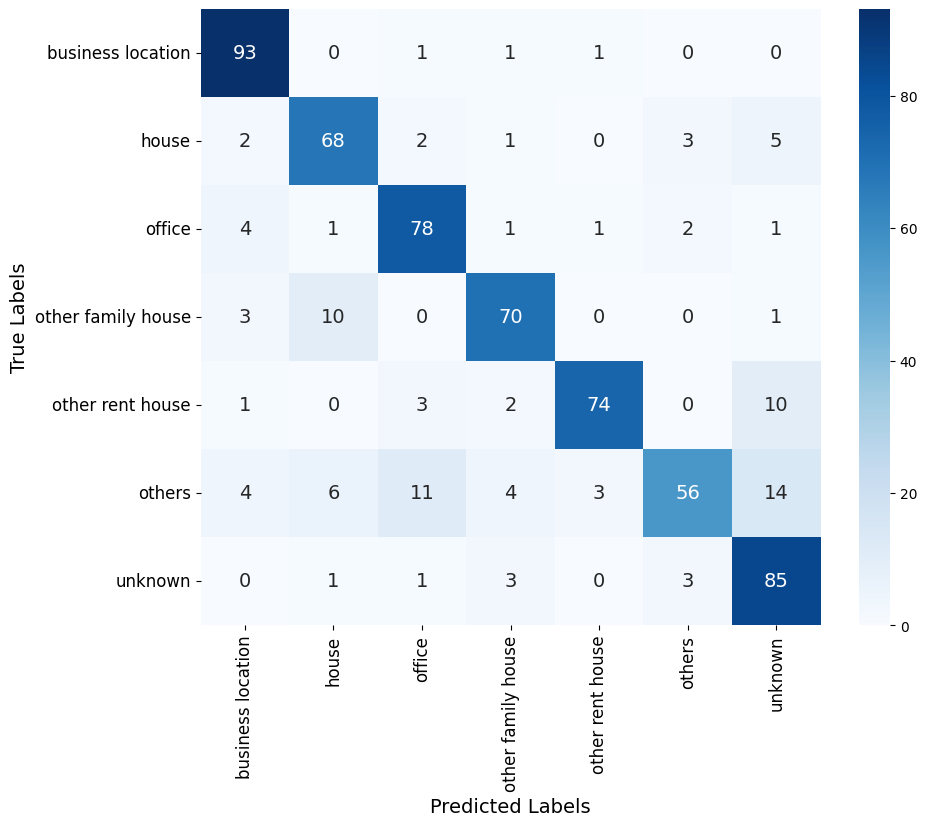

In [13]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Ambil label kelas berdasarkan nilai maksimum prediksi
y_pred_classes = np.array(pred_svm)
y_true_classes = np.array(y_test)

# Hitung confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Plot confusion matrix dengan ukuran tulisan yang lebih besar
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=SVM.classes_, yticklabels=SVM.classes_,
            annot_kws={"size": 14})  # Mengatur ukuran tulisan
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [14]:
text=[test['remarks'][0]]

In [15]:
count.fit_transform(text)

<1x3180 sparse matrix of type '<class 'numpy.int64'>'
	with 9 stored elements in Compressed Sparse Row format>

In [16]:
svc.predict(count.transform(text))

array(['other family house'], dtype=object)

In [17]:
model=make_pipeline(CountVectorizer(preprocessor=preprocessor.preprocess, vocabulary=vocabulary), LinearSVC(C=0.01))

In [18]:
model.fit(train['remarks'], train['label'])

d:\Miniconda\envs\BSD-005\lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Pipeline(steps=[('countvectorizer',
                 CountVectorizer(preprocessor=<bound method TextCleaning.preprocess of <__main__.TextCleaning object at 0x000001B130AD4BE0>>,
                                 vocabulary={'abai': 0, 'abang': 1, 'abar': 2,
                                             'abd': 3, 'abdi': 4, 'abgkat': 5,
                                             'abk': 6, 'absen': 7, 'acara': 8,
                                             'access': 9, 'account': 10,
                                             'aceh': 11, 'activity': 12,
                                             'activty': 13, 'ada': 14,
                                             'adabertemu': 15, 'adaby': 16,
                                             'adainfo': 17, 'adajanji': 18,
                                             'adajb': 19, 'adak': 20,
                                             'adakons': 21, 'adaplan': 22,
                                             'adarumah': 23, 'adasedang': 24,
                                             'adaybs': 25, 'adc': 26,
                                             'address': 27, 'adek': 28,
                                             'adha': 29, ...})),
                ('linearsvc', LinearSVC(C=0.01))])

In [19]:
model.predict(text)

array(['other family house'], dtype=object)

In [20]:
import pickle
with open('SVM_ver1.1.pkl', 'wb') as f:
    pickle.dump(model, f)